# Image classification

Now, let's tackle a slightly more complex problem: image classification!

First, the basics:

In [2]:
%matplotlib inline
# mahotas used to compute features
import mahotas as mh
import numpy as np
from matplotlib import pyplot as plt
from IPython.html.widgets import interact, fixed
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 10 x 8 inches
plt.gray()

/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## The data

This is a *subcellular location* problem.

The data is organized by directories:

    data/
        nuclear/
        cytoplasmic

The images are stored in JPEG format (which is a **terrible idea for scientific uses**, but this is a demo, and JPEG downloads faster).

We can use the ``glob`` to get the same effect as on the command line:

In [3]:
from glob import glob
images = glob('data/nuclear/*jpeg')
images += glob('data/cytoplasmic/*jpeg')

Let's just look at some basic stats on the data:

In [4]:
print("Number of images: {}".format(len(images)))

Number of images: 104


In [5]:
n_nuclear = sum(('nuclear' in im) for im in images)
print("Number of nuclear images: {}".format(n_nuclear))
print("Number of cytoplasmic images: {}".format(len(images)-n_nuclear))

Number of nuclear images: 66
Number of cytoplasmic images: 38


Image 51 is nuclear


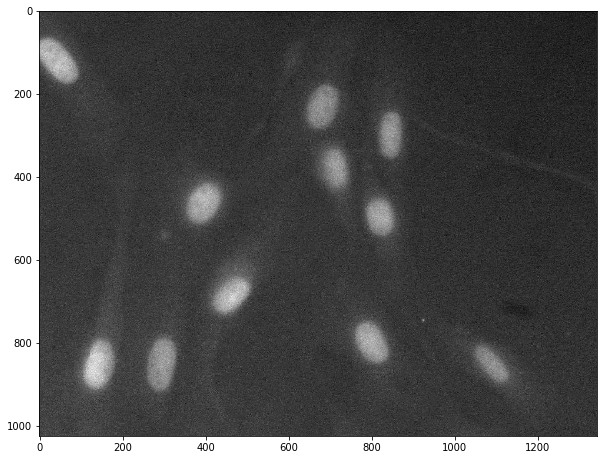

In [6]:
@interact(n=(0,len(images)-1))
def look_at_images(n):
    im = images[n]
    if 'nuclear' in images[n]:
        label = 'nuclear'
    else:
        label = 'cytoplasmic'
    print("Image {} is {}".format(n, label))
    plt.imshow(mh.stretch(mh.imread(im)))

Let's look at some images

## Classification using features

The general idea of classification using features is illustrated in the diagram below

1. take images where the label is known
2. From each compute a small number of features (*small* means *less than 1000*)
3. Use a **classifier** to smartly compare new images to the labeled ones: 


![Basic classification overview](https://upload.wikimedia.org/wikipedia/commons/c/c5/SubcellularLocationClassification.png)

### Computing features

Mahotas makes it pretty easy to compute features. We are just going to use *Haralick features* in this example:

In [9]:
im = images[0]
im = mh.imread(im)
print(mh.features.haralick(im, return_mean_ptp=True))

[  7.42386279e-02   9.99613579e-01   9.32551798e-01   7.41079298e+00
   6.97819251e-01   5.76006123e+01   2.86435583e+01   3.70511548e+00
   4.71192934e+00   7.37285050e-03   1.46904580e+00  -3.45203358e-01
   9.24203730e-01   2.09799611e-02   4.88759502e-01   3.30435698e-02
   1.27361026e-02   9.90998224e-02   1.93717580e-03   5.26066242e-01
   3.23910242e-02   3.35126649e-01   1.39261062e-03   2.59202538e-01
   1.18002637e-01   4.82309762e-02]


### Computing all features

In [10]:
# use a library function to compute features from the pictures.
features = []
is_nuclear = []
for im in images:
    is_nuclear.append('nuclear' in im)
    im = mh.imread(im)
    features.append(mh.features.haralick(im, return_mean_ptp=True))

We convert to numpy for convenience

In [ ]:
features = np.array(features)
is_nuclear = np.array(is_nuclear)

We import scikit-learn and will use a random forest classifier

In [11]:
# feed the random forest classifier using the features extracted
from sklearn import ensemble, cross_validation
clf = ensemble.RandomForestClassifier()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We now use cross-validation to obtain predictions:

In [12]:
predictions = cross_validation.cross_val_predict(clf, features, is_nuclear)

In [13]:
acc = np.mean(predictions == is_nuclear)
print("Accuracy: {:.2%}".format(acc))

# rather standard -> very bad classifier

Accuracy: 80.77%


### Looking at the errors

We can look at the images where the classifier makes mistakes:

Image 67 should have been identified as cytoplasmic (was not)


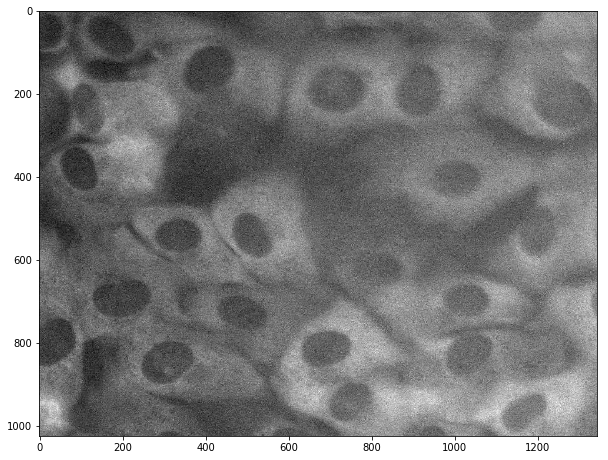

In [16]:
errors = np.where(predictions != is_nuclear)[0]
@interact(n=(0,len(errors)-1)) # interpreted by jupyter
def spot_error(n):
    err = errors[n]
    im = images[err]
    label = 'nuclear' if is_nuclear[err] else 'cytoplasmic'
    print("Image {} should have been identified as {} (was not)".format(err, label))
    plt.imshow(mh.imread(im))

## Final notes

This is not a great classification method (80% is not awful, but *nuclear* vs *cytoplasmic* is an easy problem [try ER vs cytoplasmic if you want a hard problem]). In fact, we could hope to obtain close to 100% accuracy with these data with good methods.

A large improvement could be obtained by using more features, which capture other aspects of the images, by taking into account the DNA channel (which we ignored in this exercise), or by other ides

The paper [Determining the subcellular location of new proteins from microscope images using local features](http://dx.doi.org/10.1093/bioinformatics/btt392) by Coelho et al. introduced these data and presented much better methods.


=> convoluted neuronal network: might be useful if a lot and lot of data and a problem where human do well and computer very crapily (e.g. street signs)

=> not a lot of such problems (some deep learning in biology, but rarely the case that they beat dramatically other methods)

=> in biology, not problem yet where deep learning really useful can have a breakthrough for a problem where machines struggle a lot and humans perform well 

=> for image analysis, if we use deep learning, we cannot select features. Internally, it uses some features, but we don't know a priori how it is (for picture).

Also done: take at intermediate layer of the neural network (as a pre-trained set of features) and combine with another method. Slice the middle layer, and looks at which part of the image the guys are firing at.

Unsupervised learning: hard to interpret the results (in the case of organism classification)